In [1]:
import sys
assert sys.version_info >= (3, 5)

In [2]:
import sklearn
assert sklearn.__version__ >= "0.20"

In [3]:
import tensorflow as tf
assert tf.__version__ >= "2.0"

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import os
PROJECT_ROOT_DIR = '.'
CHAPTER_ID = 'Chapter 10'
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, 'images', CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension='png', resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print('Saving figure', fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Perceptrons

In [5]:
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris()
X = iris.data[:, (2, 3)] # petal length, petal width
y = (iris.target == 0).astype(np.int64) # Iris-setosa

per_clf = Perceptron(max_iter=1000, tol=1e-3, random_state=42)
per_clf.fit(X, y)

Perceptron(random_state=42)

In [6]:
y_pred = per_clf.predict([[2, 0.5]])
y_pred

array([1], dtype=int64)

In [7]:
a = -per_clf.coef_[0][0] / per_clf.coef_[0][1]
b = -per_clf.intercept_ / per_clf.coef_[0][1]

axes = [0, 5, 0, 2]

x0, x1 = np.meshgrid(
        np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
        np.linspace(axes[2], axes[3], 200).reshape(-1, 1))
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)

Saving figure perceptron_iris_plot


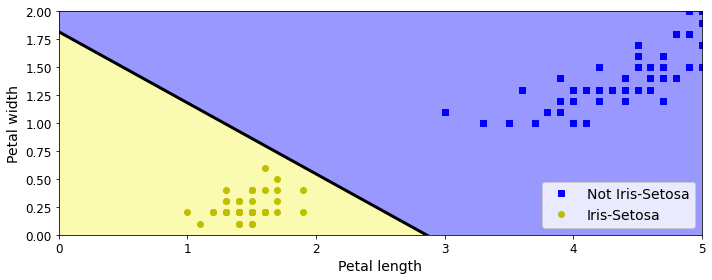

In [8]:
plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], 'bs', label='Not Iris-Setosa')
plt.plot(X[y==1, 0], X[y==1, 1], 'yo', label='Iris-Setosa')

plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], 'k-', linewidth=3)

from matplotlib.colors import ListedColormap

custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.xlabel('Petal length', fontsize=14)
plt.ylabel('Petal width', fontsize=14)
plt.legend(loc='lower right', fontsize=14)
plt.axis(axes)

save_fig('perceptron_iris_plot')
plt.show()

# Activation functions

#### Figure 10-8. Activation functions & Derivatives

In [9]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps)) / (2 * eps)

Saving figure activation_functions_plot


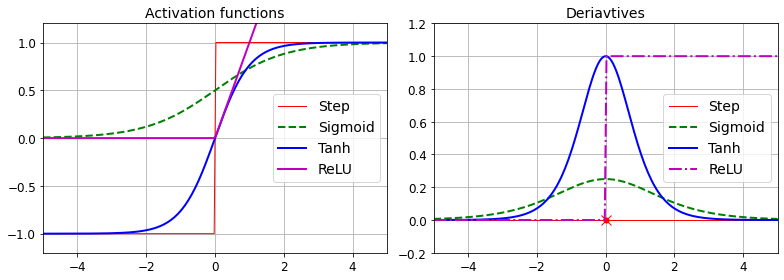

In [10]:
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(z, np.sign(z), 'r-', linewidth=1, label='Step')
plt.plot(z, sigmoid(z), 'g--', linewidth=2, label='Sigmoid')
plt.plot(z, np.tanh(z), 'b-', linewidth=2, label='Tanh')
plt.plot(z, relu(z), 'm-', linewidth=2, label='ReLU')
plt.grid(True)
plt.legend(loc='center right', fontsize=14)
plt.title('Activation functions', fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

plt.subplot(122)
plt.plot(z, derivative(np.sign,z), 'r-', linewidth=1, label='Step')
plt.plot(0, 0, 'ro', markersize=5)
plt.plot(0, 0, 'rx', markersize=10)
plt.plot(z, derivative(sigmoid, z), 'g--', linewidth=2, label='Sigmoid')
plt.plot(z, derivative(np.tanh, z), 'b-', linewidth=2, label='Tanh')
plt.plot(z, derivative(relu, z), 'm-.', linewidth=2, label='ReLU')
plt.grid(True)
plt.legend(loc='center right', fontsize=14)
plt.title('Derivatives', fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig('activation_functions_plot')
plt.show()

In [11]:
def heaviside(z):
    return (z >= 0).astype(z.dtype)

def mlp_xor(x1, x2, activation=heaviside):
    return activation(-activation(x1 + x2 - 1.5) + activation(x1 + x2 - 0.5) - 0.5)

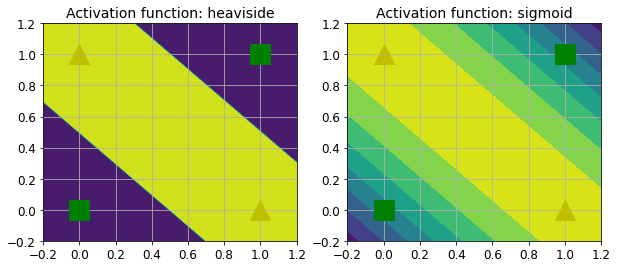

In [12]:
x1s = np.linspace(-0.2, 1.2, 100)
x2s = np.linspace(-0.2, 1.2, 100)
x1, x2 = np.meshgrid(x1s, x2s)

z1 = mlp_xor(x1, x2, activation=heaviside)
z2 = mlp_xor(x1, x2, activation=sigmoid)

plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.contourf(x1, x2, z1)
plt.plot([0, 1], [0, 1], 'gs', markersize=20)
plt.plot([0, 1], [1, 0], 'y^', markersize=20)
plt.title('Activation function: heaviside', fontsize=14)
plt.grid(True)

plt.subplot(122)
plt.contourf(x1, x2, z2)
plt.plot([0, 1], [0, 1], 'gs', markersize=20)
plt.plot([0, 1], [1, 0], 'y^', markersize=20)
plt.title('Activation function: sigmoid', fontsize=14)
plt.grid(True)

# Building an Image Classifer

In [13]:
import tensorflow as tf
from tensorflow import keras

In [14]:
tf.__version__

'2.3.4'

In [15]:
keras.__version__

'2.4.0'

In [16]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

In [17]:
print(X_train_full.shape, y_train_full.shape)
print(X_test.shape, y_test.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


In [18]:
X_train_full.dtype

dtype('uint8')

In [19]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255

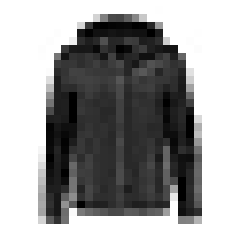

In [20]:
plt.imshow(X_train[0], cmap='binary')
plt.axis('off')
plt.show()

In [21]:
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

In [22]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [23]:
class_names[y_train[0]]

'Coat'

In [24]:
# validation set => 5000, test set => 10000
X_valid.shape, X_test.shape

((5000, 28, 28), (10000, 28, 28))

Saving figure fashion_mnist_plot


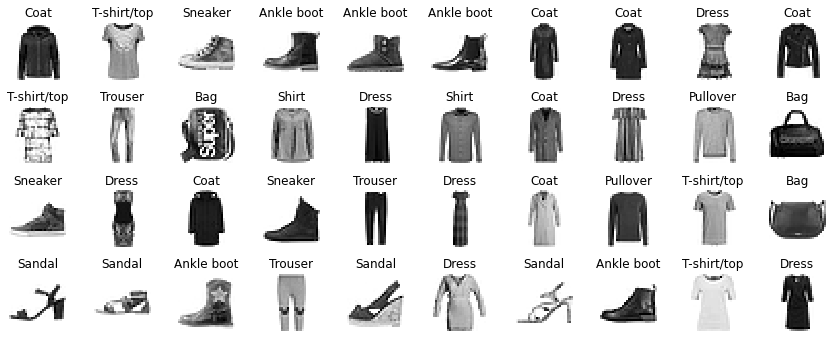

In [25]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols*1.2, n_rows*1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index+1)
        plt.imshow(X_train[index], cmap='binary', interpolation='nearest')
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_plot')
plt.show()

In [26]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation='relu'))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))

In [27]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [28]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

In [29]:
model.layers

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


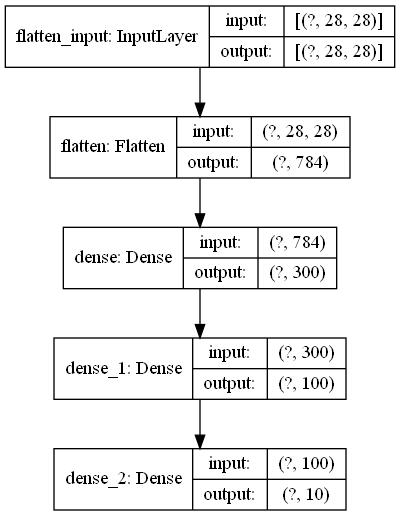

In [31]:
keras.utils.plot_model(model, 'my_fashion_mnist_model.png', show_shapes=True)

In [32]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [33]:
model.get_layer(hidden1.name) is hidden1

True

In [34]:
weights, biases = hidden1.get_weights()

In [35]:
weights

array([[ 0.02448617, -0.00877795, -0.02189048, ..., -0.02766046,
         0.03859074, -0.06889391],
       [ 0.00476504, -0.03105379, -0.0586676 , ...,  0.00602964,
        -0.02763776, -0.04165364],
       [-0.06189284, -0.06901957,  0.07102345, ..., -0.04238207,
         0.07121518, -0.07331658],
       ...,
       [-0.03048757,  0.02155137, -0.05400612, ..., -0.00113463,
         0.00228987,  0.05581069],
       [ 0.07061854, -0.06960931,  0.07038955, ..., -0.00384101,
         0.00034875,  0.02878492],
       [-0.06022581,  0.01577859, -0.02585464, ..., -0.00527829,
         0.00272203, -0.06793761]], dtype=float32)

In [36]:
weights.shape

(784, 300)

In [37]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [38]:
biases.shape

(300,)

In [39]:
model.compile(loss='sparse_categorical_crossentropy',
             optimizer='sgd',
             metrics=['accuracy'])

In [40]:
# model.compile(loss=keras.losses.sparse_categorical_crossentropy,
#              optimizer=keras.optimizers.SGD(),
#              metrics=[keras.metrics.sparse_categorical_accuracy])

In [41]:
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.7237 - accuracy: 0.7644 - val_loss: 0.5207 - val_accuracy: 0.8234
Epoch 2/30
1719/1719 [==============================] - 2s 990us/step - loss: 0.4843 - accuracy: 0.8318 - val_loss: 0.4345 - val_accuracy: 0.8538
Epoch 3/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4392 - accuracy: 0.8454 - val_loss: 0.5357 - val_accuracy: 0.7970
Epoch 4/30
1719/1719 [==============================] - 2s 996us/step - loss: 0.4126 - accuracy: 0.8564 - val_loss: 0.3915 - val_accuracy: 0.8648
Epoch 5/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3940 - accuracy: 0.8618 - val_loss: 0.3749 - val_accuracy: 0.8686
Epoch 6/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3753 - accuracy: 0.8675 - val_loss: 0.3709 - val_accuracy: 0.8714
Epoch 7/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3634 - accuracy: 0.8713 - val_loss: 0.3613 - val_accur

In [42]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 1719}

In [43]:
print(history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


In [44]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

#### Fiugre 10-12. Learning Curve: Epoch마다 측정한 평균적인 Training loss와 Accuracy 및 Epoch 종료 시점마다 측정한 평균적인 Validation loss와 Accuracy

Saving figure keras_learning_curves_plot


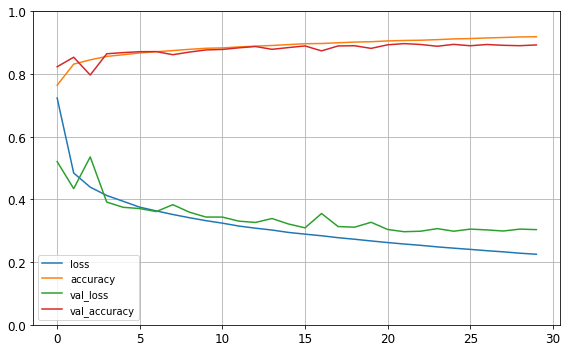

In [45]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
save_fig('keras_learning_curves_plot')
plt.show()

In [46]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 897us/step - loss: 0.3380 - accuracy: 0.8825


[0.3379794955253601, 0.8824999928474426]

In [47]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.03, 0.  , 0.96],
       [0.  , 0.  , 0.99, 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [48]:
y_pred = np.argmax(model.predict(X_new), axis=-1)
y_pred

array([9, 2, 1], dtype=int64)

Saving figure fashion_mnist_images_plot


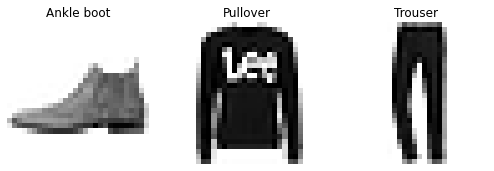

In [49]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index+1)
    plt.imshow(image, cmap='binary', interpolation='nearest')
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_images_plot')
plt.show()

# Regression MLP

In [50]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

In [51]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [52]:
np.random.seed(42)
tf.random.set_seed(42)

In [53]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation='relu', input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])

model.compile(loss='mean_squared_error', optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 0s 982us/step - loss: 1.6419 - val_loss: 0.8560
Epoch 2/20
363/363 [==============================] - 0s 779us/step - loss: 0.7047 - val_loss: 0.6531
Epoch 3/20
363/363 [==============================] - 0s 716us/step - loss: 0.6345 - val_loss: 0.6099
Epoch 4/20
363/363 [==============================] - 0s 569us/step - loss: 0.5977 - val_loss: 0.5658
Epoch 5/20
363/363 [==============================] - 0s 535us/step - loss: 0.5706 - val_loss: 0.5355
Epoch 6/20
363/363 [==============================] - 0s 622us/step - loss: 0.5472 - val_loss: 0.5173
Epoch 7/20
363/363 [==============================] - 0s 537us/step - loss: 0.5288 - val_loss: 0.5081
Epoch 8/20
363/363 [==============================] - 0s 596us/step - loss: 0.5130 - val_loss: 0.4799
Epoch 9/20
363/363 [==============================] - 0s 550us/step - loss: 0.4992 - val_loss: 0.4690
Epoch 10/20
363/363 [==============================] - 0s 711us/step - loss: 0.487

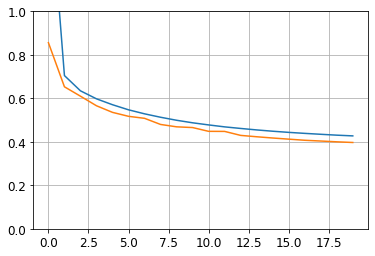

In [54]:
plt.plot(pd.DataFrame(history.history))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [55]:
y_pred

array([[0.3885664],
       [1.6792021],
       [3.1022797]], dtype=float32)

# Functional API

In [56]:
np.random.seed(42)
tf.random.set_seed(42)

In [57]:
input_ = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation='relu')(input_)
hidden2 = keras.layers.Dense(30, activation='relu')(hidden1)
concat = keras.layers.concatenate([input_, hidden2])
output = keras.layers.Dense(1)(concat)
model = keras.models.Model(inputs=[input_], outputs=[output])

In [58]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 30)           270         input_1[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 30)           930         dense_5[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 38)           0           input_1[0][0]                    
                                                                 dense_6[0][0]         

In [59]:
model.compile(loss='mean_squared_error', optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit(X_train, y_train, epochs=20,
                   validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 0s 821us/step - loss: 1.2611 - val_loss: 3.3940
Epoch 2/20
363/363 [==============================] - 0s 632us/step - loss: 0.6580 - val_loss: 0.9360
Epoch 3/20
363/363 [==============================] - 0s 624us/step - loss: 0.5878 - val_loss: 0.5649
Epoch 4/20
363/363 [==============================] - 0s 571us/step - loss: 0.5582 - val_loss: 0.5712
Epoch 5/20
363/363 [==============================] - 0s 599us/step - loss: 0.5347 - val_loss: 0.5045
Epoch 6/20
363/363 [==============================] - 0s 599us/step - loss: 0.5158 - val_loss: 0.4831
Epoch 7/20
363/363 [==============================] - 0s 594us/step - loss: 0.5002 - val_loss: 0.4639
Epoch 8/20
363/363 [==============================] - 0s 664us/step - loss: 0.4876 - val_loss: 0.4638
Epoch 9/20
363/363 [==============================] - 0s 578us/step - loss: 0.4760 - val_loss: 0.4421
Epoch 10/20
363/363 [==============================] - 0s 713us/step - loss: 0.465

In [60]:
np.random.seed(42)
tf.random.set_seed(42)

In [61]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")

hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)

concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="output")(concat)
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output])

In [62]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))

X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

history = model.fit((X_train_A, X_train_B), y_train, epochs=20,
                    validation_data=((X_valid_A, X_valid_B), y_valid))
mse_test = model.evaluate((X_test_A, X_test_B), y_test)
y_pred = model.predict((X_new_A, X_new_B))

Epoch 1/20
363/363 [==============================] - 0s 853us/step - loss: 1.8145 - val_loss: 0.8072
Epoch 2/20
363/363 [==============================] - 0s 814us/step - loss: 0.6771 - val_loss: 0.6658
Epoch 3/20
363/363 [==============================] - 0s 677us/step - loss: 0.5979 - val_loss: 0.5687
Epoch 4/20
363/363 [==============================] - 0s 609us/step - loss: 0.5584 - val_loss: 0.5296
Epoch 5/20
363/363 [==============================] - 0s 597us/step - loss: 0.5334 - val_loss: 0.4993
Epoch 6/20
363/363 [==============================] - 0s 618us/step - loss: 0.5120 - val_loss: 0.4811
Epoch 7/20
363/363 [==============================] - 0s 619us/step - loss: 0.4970 - val_loss: 0.4696
Epoch 8/20
363/363 [==============================] - 0s 688us/step - loss: 0.4843 - val_loss: 0.4496
Epoch 9/20
363/363 [==============================] - 0s 666us/step - loss: 0.4730 - val_loss: 0.4404
Epoch 10/20
363/363 [==============================] - 0s 678us/step - loss: 0.464

In [63]:
# 규제를 위한 보조 출력 추가
np.random.seed(42)
tf.random.set_seed(42)

In [64]:
input_A = keras.layers.Input(shape=[5], name='wide_input')
input_B = keras.layers.Input(shape=[6], name='deep_input')

hidden1 = keras.layers.Dense(30, activation='relu')(input_B)
hidden2 = keras.layers.Dense(30, activation='relu')(hidden1)

concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name='main_output')(concat)
aux_output = keras.layers.Dense(1, name='aux_output')(hidden2) # 보조 출력
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output, aux_output])

In [65]:
model.compile(loss=["mse", "mse"], loss_weights=[0.9, 0.1],
              optimizer=keras.optimizers.SGD(learning_rate=1e-3))

history = model.fit([X_train_A, X_train_B], [y_train, y_train], epochs=20,
                   validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid]))

Epoch 1/20
363/363 [==============================] - 0s 1ms/step - loss: 2.1365 - main_output_loss: 1.9196 - aux_output_loss: 4.0890 - val_loss: 1.6233 - val_main_output_loss: 0.8468 - val_aux_output_loss: 8.6117
Epoch 2/20
363/363 [==============================] - 0s 749us/step - loss: 0.8905 - main_output_loss: 0.6969 - aux_output_loss: 2.6326 - val_loss: 1.5163 - val_main_output_loss: 0.6836 - val_aux_output_loss: 9.0109
Epoch 3/20
363/363 [==============================] - 0s 763us/step - loss: 0.7429 - main_output_loss: 0.6088 - aux_output_loss: 1.9499 - val_loss: 1.4639 - val_main_output_loss: 0.6229 - val_aux_output_loss: 9.0326
Epoch 4/20
363/363 [==============================] - 0s 821us/step - loss: 0.6771 - main_output_loss: 0.5691 - aux_output_loss: 1.6485 - val_loss: 1.3388 - val_main_output_loss: 0.5481 - val_aux_output_loss: 8.4552
Epoch 5/20
363/363 [==============================] - 0s 952us/step - loss: 0.6381 - main_output_loss: 0.5434 - aux_output_loss: 1.4911 - 

In [66]:
total_loss, main_loss, aux_loss = model.evaluate(
        [X_test_A, X_test_B], [y_test, y_test])

y_pred_main, y_pred_aux = model.predict([X_new_A, X_new_B])

162/162 [==============================] - 0s 763us/step - loss: 0.4668 - main_output_loss: 0.4178 - aux_output_loss: 0.9082


# Subclassing API

In [67]:
class WideAndDeepModel(keras.models.Model):
    def __init__(self, units=30, activation='relu', **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(units, activation=activation)
        self.hidden2 = keras.layers.Dense(units, activation=activation)
        self.main_output = keras.layers.Dense(1)
        self.aux_output = keras.layers.Dense(1)
        
    def call(self, inputs):
        input_A, input_B = inputs
        hidden1 = self.hidden1(input_B)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input_A, hidden2])
        main_output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return main_output, aux_output

In [68]:
model = WideAndDeepModel(30, activation='relu')

In [69]:
model.compile(loss='mse', loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit((X_train_A, X_train_B), (y_train, y_train), epochs=10,
                   validation_data=((X_valid_A, X_valid_B), (y_valid, y_valid)))
total_loss, main_loss, aux_loss = model.evaluate((X_test_A, X_test_B), (y_test, y_test))
y_pred_main, y_pred_aux = model.predict((X_new_A, X_new_B))

Epoch 1/10
363/363 [==============================] - 0s 1ms/step - loss: 2.3298 - output_1_loss: 2.2186 - output_2_loss: 3.3304 - val_loss: 2.1435 - val_output_1_loss: 1.1581 - val_output_2_loss: 11.0117
Epoch 2/10
363/363 [==============================] - 0s 947us/step - loss: 0.9714 - output_1_loss: 0.8543 - output_2_loss: 2.0252 - val_loss: 1.7567 - val_output_1_loss: 0.8205 - val_output_2_loss: 10.1825
Epoch 3/10
363/363 [==============================] - 0s 926us/step - loss: 0.8268 - output_1_loss: 0.7289 - output_2_loss: 1.7082 - val_loss: 1.5664 - val_output_1_loss: 0.7913 - val_output_2_loss: 8.5419
Epoch 4/10
363/363 [==============================] - 0s 953us/step - loss: 0.7636 - output_1_loss: 0.6764 - output_2_loss: 1.5477 - val_loss: 1.3088 - val_output_1_loss: 0.6549 - val_output_2_loss: 7.1933
Epoch 5/10
363/363 [==============================] - 0s 919us/step - loss: 0.7211 - output_1_loss: 0.6402 - output_2_loss: 1.4489 - val_loss: 1.1357 - val_output_1_loss: 0.596

# Saving and Restoring

In [70]:
np.random.seed(42)
tf.random.set_seed(42)

In [71]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation='relu', input_shape=[8]),
    keras.layers.Dense(30, activation='relu'),
    keras.layers.Dense(1)
])

In [72]:
model.compile(loss='mse', optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)

Epoch 1/10
363/363 [==============================] - 0s 923us/step - loss: 1.8866 - val_loss: 0.7126
Epoch 2/10
363/363 [==============================] - 0s 786us/step - loss: 0.6577 - val_loss: 0.6880
Epoch 3/10
363/363 [==============================] - 0s 907us/step - loss: 0.5934 - val_loss: 0.5803
Epoch 4/10
363/363 [==============================] - 0s 854us/step - loss: 0.5557 - val_loss: 0.5166
Epoch 5/10
363/363 [==============================] - 0s 843us/step - loss: 0.5272 - val_loss: 0.4895
Epoch 6/10
363/363 [==============================] - 0s 868us/step - loss: 0.5033 - val_loss: 0.4951
Epoch 7/10
363/363 [==============================] - 0s 908us/step - loss: 0.4854 - val_loss: 0.4861
Epoch 8/10
363/363 [==============================] - 0s 768us/step - loss: 0.4709 - val_loss: 0.4554
Epoch 9/10
363/363 [==============================] - 0s 755us/step - loss: 0.4578 - val_loss: 0.4413
Epoch 10/10
162/162 [==============================] - 0s 573us/step - loss: 0.438

In [73]:
model.save('my_keras_model.h5')

In [74]:
model = keras.models.load_model('my_keras_model.h5')

In [75]:
model.predict(X_new)

array([[0.5400236],
       [1.650597 ],
       [3.0098243]], dtype=float32)

In [76]:
model.save_weights('my_keras_weights.ckpt')

In [77]:
model.load_weights('my_keras_weights.ckpt')

# Using Callbacks During Training

In [78]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [79]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation='relu', input_shape=[8]),
    keras.layers.Dense(30, activation='relu'),
    keras.layers.Dense(1)
])

In [80]:
# ModelCheckpoint
model.compile(loss='mse', optimizer=keras.optimizers.SGD(learning_rate=1e-3))
checkpoint_cb = keras.callbacks.ModelCheckpoint('my_keras_model.h5', save_best_only=True)
history = model.fit(X_train, y_train, epochs=10,
                   validation_data=(X_valid, y_valid),
                   callbacks=[checkpoint_cb])
model = keras.models.load_model('my_keras_model.h5')
mse_test = model.evaluate(X_test, y_test)

Epoch 1/10
363/363 [==============================] - 0s 1ms/step - loss: 1.8866 - val_loss: 0.7126
Epoch 2/10
363/363 [==============================] - 0s 845us/step - loss: 0.6577 - val_loss: 0.6880
Epoch 3/10
363/363 [==============================] - 0s 1ms/step - loss: 0.5934 - val_loss: 0.5803
Epoch 4/10
363/363 [==============================] - 0s 907us/step - loss: 0.5557 - val_loss: 0.5166
Epoch 5/10
363/363 [==============================] - 0s 833us/step - loss: 0.5272 - val_loss: 0.4895
Epoch 6/10
363/363 [==============================] - 0s 808us/step - loss: 0.5033 - val_loss: 0.4951
Epoch 7/10
363/363 [==============================] - 0s 929us/step - loss: 0.4854 - val_loss: 0.4861
Epoch 8/10
363/363 [==============================] - 0s 924us/step - loss: 0.4709 - val_loss: 0.4554
Epoch 9/10
363/363 [==============================] - 0s 958us/step - loss: 0.4578 - val_loss: 0.4413
Epoch 10/10
162/162 [==============================] - 0s 597us/step - loss: 0.4382


In [81]:
# EarlyStopping
model.compile(loss='mse', optimizer=keras.optimizers.SGD(learning_rate=1e-3))
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                 restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid),
                   callbacks=[checkpoint_cb, early_stopping_cb])
mse_test = model.evaluate(X_test, y_test)

Epoch 1/100
363/363 [==============================] - 1s 1ms/step - loss: 0.4393 - val_loss: 0.4110
Epoch 2/100
363/363 [==============================] - 0s 712us/step - loss: 0.4315 - val_loss: 0.4266
Epoch 3/100
363/363 [==============================] - 0s 864us/step - loss: 0.4259 - val_loss: 0.3996
Epoch 4/100
363/363 [==============================] - 0s 879us/step - loss: 0.4201 - val_loss: 0.3939
Epoch 5/100
363/363 [==============================] - 0s 923us/step - loss: 0.4154 - val_loss: 0.3889
Epoch 6/100
363/363 [==============================] - 0s 912us/step - loss: 0.4111 - val_loss: 0.3866
Epoch 7/100
363/363 [==============================] - 0s 930us/step - loss: 0.4074 - val_loss: 0.3860
Epoch 8/100
363/363 [==============================] - 0s 920us/step - loss: 0.4040 - val_loss: 0.3793
Epoch 9/100
363/363 [==============================] - 0s 938us/step - loss: 0.4008 - val_loss: 0.3746
Epoch 10/100
363/363 [==============================] - 0s 1ms/step - loss:

In [82]:
class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print(f'\nval/train: {logs["val_loss"] / logs["loss"]:.2f}')

In [83]:
val_train_ratio_cb = PrintValTrainRatioCallback()
history = model.fit(X_train, y_train, epochs=1,
                   validation_data=(X_valid, y_valid),
                   callbacks=[val_train_ratio_cb])

289/363 [======================>.......] - ETA: 0s - loss: 0.3339
val/train: 1.08
363/363 [==============================] - 0s 965us/step - loss: 0.3302 - val_loss: 0.3559


# TensorBoard

In [84]:
root_logdir = os.path.join(os.curdir, 'my_logs')

In [85]:
def get_run_logdir():
    import time
    run_id = time.strftime('run_%Y_%m_%d_%H_%M_%S')
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
run_logdir

'.\\my_logs\\run_2023_02_09_15_21_22'

In [86]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [87]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation='relu', input_shape=[8]),
    keras.layers.Dense(30, activation='relu'),
    keras.layers.Dense(1)
])

In [88]:
model.compile(loss='mse', optimizer=keras.optimizers.SGD(learning_rate=1e-3))

In [89]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
history = model.fit(X_train, y_train, epochs=30,
                   validation_data=(X_valid, y_valid),
                   callbacks=[checkpoint_cb, tensorboard_cb])

Epoch 1/30
  1/363 [..............................] - ETA: 0s - loss: 7.8215WARNING:tensorflow:From C:\Users\82104\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
363/363 [==============================] - 1s 2ms/step - loss: 1.8866 - val_loss: 0.7126
Epoch 2/30
363/363 [==============================] - 0s 1ms/step - loss: 0.6577 - val_loss: 0.6880
Epoch 3/30
363/363 [==============================] - 0s 1ms/step - loss: 0.5934 - val_loss: 0.5803
Epoch 4/30
363/363 [==============================] - 0s 1ms/step - loss: 0.5557 - val_loss: 0.5166
Epoch 5/30
363/363 [==============================] - 0s 1ms/step - loss: 0.5272 - val_loss: 0.4895
Epoch 6/30
363/363 [==============================] - 0s 898us/step - loss: 0.5033 - val_loss: 0.4951
Epoch 7/30
363/363 [==============================]

#### Tensorboard launch


```bash
$ tensorboard --logdir=./my_logs --port=6006
```

그다음 웹 브라우저를 열고 [localhost:6006](http://localhost:6006)에 접속하면 텐서보드를 사용할 수 있습니다. 사용이 끝나면 터미널에서 Ctrl-C를 눌러 텐서보드 서버를 종료하세요.

In [124]:
# %load_ext tensorboard
# %tensorboard --logdir='./HUFS_jupyter/Gnuvil/2023-1 Gnuvil/my_logs' --port=6006

In [93]:
run_logdir2 = get_run_logdir()
run_logdir2

'.\\my_logs\\run_2023_02_09_15_30_35'

In [102]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [103]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    

In [104]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=0.05))

In [105]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir2)
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, tensorboard_cb])

Epoch 1/30
363/363 [==============================] - 0s 823us/step - loss: 0.5530 - val_loss: 302.8533
Epoch 2/30
363/363 [==============================] - 0s 522us/step - loss: 18463.0098 - val_loss: 8.5567
Epoch 3/30
363/363 [==============================] - 0s 497us/step - loss: 1.3411 - val_loss: 8.5551
Epoch 4/30
363/363 [==============================] - 0s 490us/step - loss: 1.3423 - val_loss: 8.5582
Epoch 5/30
363/363 [==============================] - 0s 610us/step - loss: 1.3423 - val_loss: 8.5559
Epoch 6/30
363/363 [==============================] - 0s 538us/step - loss: 1.3431 - val_loss: 8.5557
Epoch 7/30
363/363 [==============================] - 0s 534us/step - loss: 1.3425 - val_loss: 8.5568
Epoch 8/30
363/363 [==============================] - 0s 542us/step - loss: 1.3433 - val_loss: 8.5556
Epoch 9/30
363/363 [==============================] - 0s 562us/step - loss: 1.3435 - val_loss: 8.5566
Epoch 10/30
363/363 [==============================] - 0s 537us/step - loss:

In [106]:
help(keras.callbacks.TensorBoard.__init__)

Help on function __init__ in module tensorflow.python.keras.callbacks:

__init__(self, log_dir='logs', histogram_freq=0, write_graph=True, write_images=False, update_freq='epoch', profile_batch=2, embeddings_freq=0, embeddings_metadata=None, **kwargs)
    Initialize self.  See help(type(self)) for accurate signature.



# Hyperparameter Tuning

In [107]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [108]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[8]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation='relu'))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
    model.compile(loss='mse', optimizer=optimizer)
    return model

In [109]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

In [110]:
keras_reg.fit(X_train, y_train, epochs=100,
             validation_data=(X_valid, y_valid),
             callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/100
363/363 [==============================] - 0s 648us/step - loss: 1.0896 - val_loss: 20.7721
Epoch 2/100
363/363 [==============================] - 0s 525us/step - loss: 0.7606 - val_loss: 5.0266
Epoch 3/100
363/363 [==============================] - 0s 488us/step - loss: 0.5456 - val_loss: 0.5490
Epoch 4/100
363/363 [==============================] - 0s 491us/step - loss: 0.4732 - val_loss: 0.4529
Epoch 5/100
363/363 [==============================] - 0s 621us/step - loss: 0.4503 - val_loss: 0.4188
Epoch 6/100
363/363 [==============================] - 0s 544us/step - loss: 0.4338 - val_loss: 0.4129
Epoch 7/100
363/363 [==============================] - 0s 468us/step - loss: 0.4241 - val_loss: 0.4004
Epoch 8/100
363/363 [==============================] - 0s 452us/step - loss: 0.4168 - val_loss: 0.3944
Epoch 9/100
363/363 [==============================] - 0s 458us/step - loss: 0.4108 - val_loss: 0.3961
Epoch 10/100
363/363 [==============================] - 0s 462us/step - 

Epoch 80/100
363/363 [==============================] - 0s 481us/step - loss: 0.3376 - val_loss: 0.3557
Epoch 81/100
363/363 [==============================] - 0s 488us/step - loss: 0.3383 - val_loss: 0.3406
Epoch 82/100
363/363 [==============================] - 0s 525us/step - loss: 0.3370 - val_loss: 0.3223
Epoch 83/100
363/363 [==============================] - 0s 465us/step - loss: 0.3367 - val_loss: 0.3348
Epoch 84/100
363/363 [==============================] - 0s 623us/step - loss: 0.3362 - val_loss: 0.4190
Epoch 85/100
363/363 [==============================] - 0s 517us/step - loss: 0.3370 - val_loss: 0.3307
Epoch 86/100
363/363 [==============================] - 0s 485us/step - loss: 0.3359 - val_loss: 0.3355
Epoch 87/100
363/363 [==============================] - 0s 465us/step - loss: 0.3356 - val_loss: 0.3690
Epoch 88/100
363/363 [==============================] - 0s 486us/step - loss: 0.3357 - val_loss: 0.3209
Epoch 89/100
363/363 [==============================] - 0s 663us

In [111]:
mse_test = keras_reg.score(X_test, y_test)

162/162 [==============================] - 0s 348us/step - loss: 0.3380


In [112]:
y_pred = keras_reg.predict(X_new)

In [113]:
np.random.seed(42)
tf.random.set_seed(42)

In [114]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_hidden" : [0, 1, 2, 3],
    "n_neurons" : np.arange(1, 100).tolist(),
    "learning_rate" : reciprocal(3e-4, 3e-2).rvs(1000).tolist(),
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3, verbose=2)
rnd_search_cv.fit(X_train, y_train, epochs=100,
                 validation_data=(X_valid, y_valid),
                 callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] n_neurons=4, n_hidden=1, learning_rate=0.022174573948353458 .....
Epoch 1/100
  1/242 [..............................] - ETA: 0s - loss: 5.3594

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


242/242 [==============================] - 0s 804us/step - loss: 0.8420 - val_loss: 0.4703
Epoch 2/100
242/242 [==============================] - 0s 562us/step - loss: 0.4815 - val_loss: 0.4247
Epoch 3/100
242/242 [==============================] - 0s 553us/step - loss: 0.4519 - val_loss: 0.4052
Epoch 4/100
242/242 [==============================] - 0s 532us/step - loss: 0.4429 - val_loss: 0.3975
Epoch 5/100
242/242 [==============================] - 0s 538us/step - loss: 0.4368 - val_loss: 0.3991
Epoch 6/100
242/242 [==============================] - 0s 580us/step - loss: 0.4340 - val_loss: 0.4031
Epoch 7/100
242/242 [==============================] - 0s 530us/step - loss: 0.4351 - val_loss: 0.4043
Epoch 8/100
242/242 [==============================] - 0s 577us/step - loss: 0.4267 - val_loss: 0.3929
Epoch 9/100
242/242 [==============================] - 0s 539us/step - loss: 0.4258 - val_loss: 0.4040
Epoch 10/100
242/242 [==============================] - 0s 517us/step - loss: 0.4237 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s


242/242 [==============================] - 0s 765us/step - loss: 0.7452 - val_loss: 0.4860
Epoch 2/100
242/242 [==============================] - 0s 537us/step - loss: 0.4649 - val_loss: 0.4280
Epoch 3/100
242/242 [==============================] - 0s 538us/step - loss: 0.4495 - val_loss: 0.5791
Epoch 4/100
242/242 [==============================] - 0s 551us/step - loss: 0.4438 - val_loss: 0.4549
Epoch 5/100
242/242 [==============================] - 0s 590us/step - loss: 0.4414 - val_loss: 0.5250
Epoch 6/100
242/242 [==============================] - 0s 562us/step - loss: 0.4409 - val_loss: 0.5486
Epoch 7/100
242/242 [==============================] - 0s 535us/step - loss: 0.4388 - val_loss: 0.5871
Epoch 8/100
242/242 [==============================] - 0s 544us/step - loss: 0.4381 - val_loss: 0.4759
Epoch 9/100
242/242 [==============================] - 0s 535us/step - loss: 0.4371 - val_loss: 0.7523
Epoch 10/100
242/242 [==============================] - 0s 557us/step - loss: 0.4369 

Epoch 43/100
242/242 [==============================] - 0s 575us/step - loss: 0.4867 - val_loss: 0.4646
Epoch 44/100
242/242 [==============================] - 0s 586us/step - loss: 0.4837 - val_loss: 0.4636
Epoch 45/100
242/242 [==============================] - 0s 684us/step - loss: 0.4809 - val_loss: 0.4616
Epoch 46/100
242/242 [==============================] - 0s 660us/step - loss: 0.4781 - val_loss: 0.4582
Epoch 47/100
242/242 [==============================] - 0s 596us/step - loss: 0.4755 - val_loss: 0.4581
Epoch 48/100
242/242 [==============================] - 0s 761us/step - loss: 0.4729 - val_loss: 0.4573
Epoch 49/100
242/242 [==============================] - 0s 694us/step - loss: 0.4704 - val_loss: 0.4560
Epoch 50/100
242/242 [==============================] - 0s 695us/step - loss: 0.4680 - val_loss: 0.4544
Epoch 51/100
242/242 [==============================] - 0s 674us/step - loss: 0.4656 - val_loss: 0.4525
Epoch 52/100
242/242 [==============================] - 0s 741us

Epoch 67/100
242/242 [==============================] - 0s 689us/step - loss: 0.4422 - val_loss: 0.4164
Epoch 68/100
242/242 [==============================] - 0s 670us/step - loss: 0.4408 - val_loss: 0.4151
Epoch 69/100
242/242 [==============================] - 0s 651us/step - loss: 0.4395 - val_loss: 0.4141
Epoch 70/100
242/242 [==============================] - 0s 738us/step - loss: 0.4382 - val_loss: 0.4124
Epoch 71/100
242/242 [==============================] - 0s 723us/step - loss: 0.4369 - val_loss: 0.4112
Epoch 72/100
242/242 [==============================] - 0s 714us/step - loss: 0.4357 - val_loss: 0.4101
Epoch 73/100
242/242 [==============================] - 0s 673us/step - loss: 0.4345 - val_loss: 0.4088
Epoch 74/100
242/242 [==============================] - 0s 734us/step - loss: 0.4334 - val_loss: 0.4081
Epoch 75/100
242/242 [==============================] - 0s 795us/step - loss: 0.4323 - val_loss: 0.4073
Epoch 76/100
242/242 [==============================] - 0s 664us

Epoch 24/100
242/242 [==============================] - 0s 771us/step - loss: 0.3774 - val_loss: 0.4022
Epoch 25/100
242/242 [==============================] - 0s 799us/step - loss: 0.3756 - val_loss: 0.3729
Epoch 26/100
242/242 [==============================] - 0s 792us/step - loss: 0.3733 - val_loss: 0.3645
Epoch 27/100
242/242 [==============================] - 0s 783us/step - loss: 0.3716 - val_loss: 0.4107
Epoch 28/100
242/242 [==============================] - 0s 706us/step - loss: 0.3702 - val_loss: 0.3925
Epoch 29/100
242/242 [==============================] - 0s 732us/step - loss: 0.3688 - val_loss: 0.4265
Epoch 30/100
242/242 [==============================] - 0s 775us/step - loss: 0.3677 - val_loss: 0.3879
Epoch 31/100
242/242 [==============================] - 0s 711us/step - loss: 0.3659 - val_loss: 0.3789
Epoch 32/100
242/242 [==============================] - 0s 733us/step - loss: 0.3643 - val_loss: 0.4080
Epoch 33/100
242/242 [==============================] - 0s 777us

242/242 [==============================] - 0s 982us/step - loss: 1.2632 - val_loss: 1.4543
Epoch 2/100
242/242 [==============================] - 0s 741us/step - loss: 0.6364 - val_loss: 0.9557
Epoch 3/100
242/242 [==============================] - 0s 867us/step - loss: 0.5396 - val_loss: 0.4628
Epoch 4/100
242/242 [==============================] - 0s 680us/step - loss: 0.4783 - val_loss: 0.4214
Epoch 5/100
242/242 [==============================] - 0s 737us/step - loss: 0.4400 - val_loss: 0.3984
Epoch 6/100
242/242 [==============================] - 0s 739us/step - loss: 0.4169 - val_loss: 0.4056
Epoch 7/100
242/242 [==============================] - 0s 688us/step - loss: 0.4004 - val_loss: 0.3741
Epoch 8/100
242/242 [==============================] - 0s 719us/step - loss: 0.3888 - val_loss: 0.3926
Epoch 9/100
242/242 [==============================] - 0s 716us/step - loss: 0.3809 - val_loss: 0.3832
Epoch 10/100
242/242 [==============================] - 0s 881us/step - loss: 0.3743 

242/242 [==============================] - 0s 809us/step - loss: 0.3962 - val_loss: 0.4241
Epoch 26/100
242/242 [==============================] - 0s 912us/step - loss: 0.3944 - val_loss: 0.3779
Epoch 27/100
242/242 [==============================] - 0s 949us/step - loss: 0.3925 - val_loss: 0.4126
Epoch 28/100
242/242 [==============================] - 0s 887us/step - loss: 0.3910 - val_loss: 0.3967
Epoch 29/100
242/242 [==============================] - 0s 941us/step - loss: 0.3889 - val_loss: 0.4045
Epoch 30/100
242/242 [==============================] - 0s 796us/step - loss: 0.3880 - val_loss: 0.3748
Epoch 31/100
242/242 [==============================] - 0s 840us/step - loss: 0.3864 - val_loss: 0.3717
Epoch 32/100
242/242 [==============================] - 0s 963us/step - loss: 0.3851 - val_loss: 0.3676
Epoch 33/100
242/242 [==============================] - 0s 951us/step - loss: 0.3837 - val_loss: 0.4054
Epoch 34/100
242/242 [==============================] - 0s 969us/step - loss:

242/242 [==============================] - 0s 978us/step - loss: 0.3729 - val_loss: 0.5255
Epoch 43/100
242/242 [==============================] - 0s 974us/step - loss: 0.3744 - val_loss: 0.7023
Epoch 44/100
242/242 [==============================] - 0s 926us/step - loss: 0.3741 - val_loss: 0.7508
Epoch 45/100
121/121 [==============================] - 0s 566us/step - loss: 0.3745
[CV]  n_neurons=49, n_hidden=1, learning_rate=0.0020587676114196545, total=  10.9s
[CV] n_neurons=74, n_hidden=3, learning_rate=0.005803602934201024 ....
Epoch 1/100
242/242 [==============================] - 0s 1ms/step - loss: 1.0682 - val_loss: 6.4183
Epoch 2/100
242/242 [==============================] - 0s 1ms/step - loss: 0.7154 - val_loss: 16.7917
Epoch 3/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5830 - val_loss: 4.7824
Epoch 4/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4475 - val_loss: 8.6078
Epoch 5/100
242/242 [==============================] - 0s

242/242 [==============================] - 0s 1ms/step - loss: 0.2718 - val_loss: 0.3111
Epoch 60/100
242/242 [==============================] - 0s 1ms/step - loss: 0.2715 - val_loss: 0.2861
Epoch 61/100
242/242 [==============================] - 0s 1ms/step - loss: 0.2697 - val_loss: 0.4036
Epoch 62/100
242/242 [==============================] - 0s 1ms/step - loss: 0.2707 - val_loss: 0.2942
Epoch 63/100
242/242 [==============================] - 0s 1ms/step - loss: 0.2689 - val_loss: 0.4175
Epoch 64/100
242/242 [==============================] - 0s 1ms/step - loss: 0.2690 - val_loss: 0.2860
Epoch 65/100
121/121 [==============================] - 0s 624us/step - loss: 0.2886
[CV]  n_neurons=74, n_hidden=3, learning_rate=0.005803602934201024, total=  20.0s
[CV] n_neurons=80, n_hidden=3, learning_rate=0.0059640580092043885 ...
Epoch 1/100
242/242 [==============================] - 0s 1ms/step - loss: 0.9615 - val_loss: 10.9251
Epoch 2/100
242/242 [==============================] - 0s 1ms

Epoch 9/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3456 - val_loss: 1.2255
Epoch 10/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3424 - val_loss: 0.8015
Epoch 11/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3373 - val_loss: 0.8351
Epoch 12/100
121/121 [==============================] - 0s 671us/step - loss: 0.3595
[CV]  n_neurons=80, n_hidden=3, learning_rate=0.0059640580092043885, total=   3.9s
[CV] n_neurons=80, n_hidden=3, learning_rate=0.0059640580092043885 ...
Epoch 1/100
242/242 [==============================] - 0s 2ms/step - loss: 0.8683 - val_loss: 2.2007
Epoch 2/100
242/242 [==============================] - 0s 1ms/step - loss: 0.5072 - val_loss: 3.3028
Epoch 3/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4486 - val_loss: 0.9130
Epoch 4/100
242/242 [==============================] - 0s 1ms/step - loss: 0.4071 - val_loss: 0.5328
Epoch 5/100
242/242 [==============================]

Epoch 41/100
242/242 [==============================] - 0s 967us/step - loss: 0.3187 - val_loss: 0.3146
Epoch 42/100
242/242 [==============================] - 0s 988us/step - loss: 0.3149 - val_loss: 0.3145
Epoch 43/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3148 - val_loss: 0.3103
Epoch 44/100
242/242 [==============================] - 0s 1ms/step - loss: 0.3112 - val_loss: 0.3410
Epoch 45/100
242/242 [==============================] - 0s 959us/step - loss: 0.3145 - val_loss: 0.3052
Epoch 46/100
242/242 [==============================] - 0s 891us/step - loss: 0.3103 - val_loss: 0.3341
Epoch 47/100
242/242 [==============================] - 0s 974us/step - loss: 0.3089 - val_loss: 0.3333
Epoch 48/100
242/242 [==============================] - 0s 894us/step - loss: 0.3121 - val_loss: 0.3181
Epoch 49/100
242/242 [==============================] - 0s 926us/step - loss: 0.3075 - val_loss: 0.3022
Epoch 50/100
242/242 [==============================] - 0s 866us/ste

Epoch 19/100
242/242 [==============================] - 0s 881us/step - loss: 0.3535 - val_loss: 0.3371
Epoch 20/100
242/242 [==============================] - 0s 831us/step - loss: 0.3485 - val_loss: 0.4118
Epoch 21/100
242/242 [==============================] - 0s 762us/step - loss: 0.3485 - val_loss: 0.3311
Epoch 22/100
242/242 [==============================] - 0s 768us/step - loss: 0.3460 - val_loss: 0.3289
Epoch 23/100
242/242 [==============================] - 0s 711us/step - loss: 0.3435 - val_loss: 0.3287
Epoch 24/100
242/242 [==============================] - 0s 750us/step - loss: 0.3410 - val_loss: 0.5230
Epoch 25/100
242/242 [==============================] - 0s 751us/step - loss: 0.3438 - val_loss: 0.7683
Epoch 26/100
242/242 [==============================] - 0s 806us/step - loss: 0.3423 - val_loss: 0.8920
Epoch 27/100
242/242 [==============================] - 0s 886us/step - loss: 0.3449 - val_loss: 0.4875
Epoch 28/100
242/242 [==============================] - 0s 788us

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  4.3min finished


363/363 [==============================] - 0s 917us/step - loss: 0.8194 - val_loss: 1.8036
Epoch 2/100
363/363 [==============================] - 0s 713us/step - loss: 0.4857 - val_loss: 2.0827
Epoch 3/100
363/363 [==============================] - 0s 761us/step - loss: 0.4266 - val_loss: 0.3796
Epoch 4/100
363/363 [==============================] - 0s 801us/step - loss: 0.3857 - val_loss: 0.4283
Epoch 5/100
363/363 [==============================] - 0s 902us/step - loss: 0.3740 - val_loss: 0.3617
Epoch 6/100
363/363 [==============================] - 0s 852us/step - loss: 0.3620 - val_loss: 0.4566
Epoch 7/100
363/363 [==============================] - 0s 794us/step - loss: 0.3566 - val_loss: 0.3573
Epoch 8/100
363/363 [==============================] - 0s 684us/step - loss: 0.3492 - val_loss: 0.3380
Epoch 9/100
363/363 [==============================] - 0s 703us/step - loss: 0.3432 - val_loss: 0.3757
Epoch 10/100
363/363 [==============================] - 0s 816us/step - loss: 0.3389 

RandomizedSearchCV(cv=3,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x0000021AD6CA6C40>,
                   param_distributions={'learning_rate': [0.001683454924600351,
                                                          0.02390836445593178,
                                                          0.008731907739399206,
                                                          0.004725396149933917,
                                                          0.0006154014789262348,
                                                          0.0006153331256530192,
                                                          0.0003920021771415983,
                                                          0.01619845322936229,
                                                          0.004779156784872302...
                                                          0.005021425736625637,
                                                  

In [115]:
rnd_search_cv.best_params_

{'n_neurons': 74, 'n_hidden': 3, 'learning_rate': 0.005803602934201024}

In [116]:
rnd_search_cv.best_score_

-0.31684500972429913

In [117]:
rnd_search_cv.best_estimator_

In [118]:
rnd_search_cv.score(X_test, y_test)

162/162 [==============================] - 0s 381us/step - loss: 0.3039


-0.3038526177406311

In [119]:
model = rnd_search_cv.best_estimator_.model
model

In [120]:
model.evaluate(X_test, y_test)

162/162 [==============================] - 0s 471us/step - loss: 0.3039


0.3038526177406311